(chap:6-regression)=

# 回帰分析

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [1]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## はじめに

この章の目的は２つある。第一に，`Python`を使って回帰分析の方法を紹介する事である。読者には統計学や計量経済学を学び，実際にソフトを使い回帰分析をした経験を持つ人も多く含まれると思う。例えば，無料のRやGretl，そして有料ではあるがStataやEViewsあたりが人気ではないだろうか。`Python`でも回帰分析を簡単におこなうことが可能であり，有名な`statsmodels`と`linearmodels`パッケージを使うと学部の授業で習うことは殆ど全て可能だろう。この章では基本的な回帰分析を考えるので`statsmodels`だけを取り上げ，その基本的なコードを紹介するが，より多くを知りたい場合は[「Pythonで学ぶ入門計量経済学」](https://py4etrics.github.io)を参照して欲しい。

この章の第二の目的は，[発展会計](chap:5a-accounting)と[成長会計](chap:5b-accounting)の章で考察した問題を再考することである。その章では，全要素生産性と蓄積生産要素の２つにフォーカスし，それぞれが一人当たりGDPの水準と成長率にどれだけ貢献しているかを考えた。その際，寄与度として分散と共分散を使い計算したが，回帰分析を使うと簡単に計算できる事を示す。更に，回帰分析を使い，所得が低い経済は所得が高い経済にキャッチアップしているかを検討する。

## `Python`を使った回帰分析 

[発展会計](chap:5a-accounting)の章で経済間の所得格差の要因を考え，[全要素生産性](sec:5a-tfp)のセクションで全要素生産性と一人当たりGDPの散布図を作成した。そのデータを使い回帰分析のためのコードの書き方を説明する。

### データ

まずデータを作成する。

In [2]:
df2019 = py4macro.data('pwt') \
                 .query('year == 2019') \
                 .reset_index(drop=True)

```{admonition} コードの説明
:class: dropdown

* `py4macro.data()`は`DataFrame`を返すため，そのメソッド`query()`を続けて使っている。また`query()`も`DataFrame`を返すため，そのメソッド`reset_index()`を続けて使っている。
* `\`を使うと改行が可能となる。
* `query('year == 2019')`を使って2019年のデータだけを抽出したが，その際に行インデックスが飛び飛びになるので，それを`0`，`1`，`2`....と番号を振り直すために`reset_index()`を使っている。引数`drop=True`がないと，元の飛び飛びの行インデックスが新たな列として残るため，それを残さないようにしている。
```

発展会計の分析で使った同じ変数を作成しよう。

In [3]:
# 資本の所得シャア
a=1/3.0

# 労働者一人当たりGDP
df2019['gdp_pc'] = df2019['cgdpo'] / df2019['emp']

# 労働者一人当たり資本
df2019['k_pc'] = df2019['ck'] / df2019['emp']

# 蓄積生産要素
df2019['factors'] = df2019['k_pc']**a * ( df2019['avh']*df2019['hc'] )**(1-a)

# 全要素生産性
df2019['tfp'] = df2019['gdp_pc'] / df2019['factors']

# 米国のデータ
us2019 = df2019.query('country == "United States"')

# 労働者一人当たりGDPを標準化（USA=1）
df2019['gdp_pc_relative'] = df2019['gdp_pc'] / us2019['gdp_pc'].to_numpy()

# 全要素生産性の標準化（USA=1）
df2019['tfp_relative'] = df2019['tfp'] / us2019['tfp'].to_numpy()

# 蓄積生産要素の標準化（USA=1）
df2019['factors_relative'] = df2019['factors'] / us2019['factors'].to_numpy()

全要素生産性と一人当たりGDPの散布図を作成しよう。

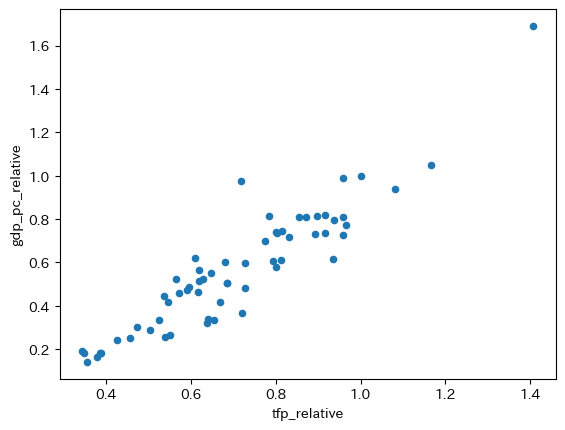

In [4]:
df2019.plot('tfp_relative', 'gdp_pc_relative', kind='scatter')
pass

### 回帰分析

上の散布図に直線のトレンドの描く場合

$$
y_i = a+bA_i
$$ (eq:6-regression)

となり，`i`は個々の観測値（即ち，経済）を表す。ここでの目的は，散布図のデータを使い定数項`a`とスロープ係数`b`を計算し直線トレンドを描く事である。

式[](eq:6-regression)のパラメータ`b`を推計するために`statsmodels`パッケージを使うが，そのサブパッケージ`formula.api`の中に含まれる`ols`を使うことにより、最小二乗法の多くの計算（例えば、検定値など）を自動で行うことが可能である。また推定式を文字列で書くことができるので直感的にコードを書くことが可能となる。より具体的な説明は[このサイト](https://py4etrics.github.io)を参照してほしい。

次のステップでコードを書く。
1. 文字列で推定式を書く。
1. `ols`を使って推定の準備を行う。
1. メソッド`.fit()`を使って自動計算を行う。
1. 結果の属性やメソッドを使い推定値を表示する。

**＜ステップ１＞** 推定式の設定

回帰式は次のような形で文字列を使って指定する。
```
'被説明変数 ~ 定数項以外の説明変数'
```
定数項は自動的に挿入される。また定数項以外の説明変数が複数がる場合は、`+`でつなげるが，今回は単回帰分析となるので説明変数は１つとなる。また回帰式の中で使う変数名は，データが含まれる`DataFrame`の列ラベルを使う。
```
'gdp_pc_relative ~ tfp_relative'
```
以下ではこの回帰式を変数`formula`に割り当てているが，変数は分かりやすいものであれば好きなものを使えば良い。

In [5]:
formula = 'gdp_pc_relative ~ tfp_relative'

**＜ステップ２＞** 自動計算の準備

`sm`の`ols`を使って自動計算の準備として計算の対象となるもの（インスタンスと呼ばれるオブジェクト）を生成する。次のコードでは変数`model`に割り当てる。

In [6]:
model = smf.ols(formula, data=df2019)

`ols()`の第１引数は上で定義した文字列の回帰式であり、第２引数`data`は使用するデータを指定する。

**＜ステップ３＞** 自動計算

`model`のメソッド`.fit()`を使って自動計算し，計算した結果を変数`result`に割り当てる。

In [7]:
result = model.fit()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ここでステップ２と３を連続で次のように書いても構わない。
```
result = ols(formula, data=df).fit()
```

**＜ステップ４＞** 結果の表示

`result`には様々な属性が用意されているが、メソッド`.summary()`を使うと基本的な推定結果を表示することができる。（関数`print()`を使っているが使わなくても同じ情報が表示される。）

In [8]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        gdp_pc_relative   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     336.7
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           4.64e-26
Time:                        18:53:21   Log-Likelihood:                 49.767
No. Observations:                  61   AIC:                            -95.53
Df Residuals:                      59   BIC:                            -91.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2821      0.049     -5.812   

表は3つのセクションから構成されている。
* 上段にはOLS推定の基本的な情報が表示されている。
    * 左側
        * `Dep. Variable`：被説明変数
        * `Model`：モデル
        * `Method`：手法
        * `Data`：日にち
        * `Time`：時間
        * `No. Observation`：標本の大きさ
        * `Df Residuals`：残差の自由度
        * `Df Model`：モデルの自由度（定数項以外の説明変数の数）
        * `Covariance Type`：共分散のタイプ
    * 右側
        * `R-squared`：決定係数
        * `adj. R-squared`：自由度調整済み決定係数
        * `F-statistic`：$F$統計量
        * `Prob (F-statistic)`：$F$値
        * `Log-Likelihood`：対数尤度
        * `AIC`：赤池情報量規準
        * `BIC`：ベイズ情報量規準
* 中段には主な推定結果が表示される。
    * 列ラベル
        * `coef`：係数
        * `std err`：標準誤差
        * `t`：$t$値
        * `P>|t|`：$p$値
        * `[0.025,0.975]`：信頼区間（5%)
    * 行ラベル
        * `Intercept`：定数項
        * `tfp_relative`：説明変数（選択する変数によって変わる）
* 下段には様々な検定などに関する数値が並んでいる。
    * 左側
        * `Omnibus`：オムニバス検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(Omnibus)`：オムニバス検定$p$値
        * `Skew`：残差の歪度（正規分布であれば`0`）
        * `Kurtosis`：残差の尖度（正規分布であれば`3`）
    * 右側
        * `Durbin-Watson`：ダービン・ワトソン統計量（残差の自己相関の検定）
        * `Jarque-Bera (JB)`：ジャーク・ベラ検定統計量（帰無仮説：残差は正規分布に従う）
        * `Prob(JB)`：ジャーク・ベラ検定$p$値
        * `Cond. No.`：条件指数（Condition Index）の最大値（多重共線性を確認するための指標だが，変数が標準化されて計算していないため変数の値の大きさに依存することになるり，使い難い指標となっている。重回帰分析においての多重共線性の確認については[ここで説明](https://py4etrics.github.io/9_Multiple_Regression.html#sec-9-vif)する手法を使うことを勧める。）

必要な部分だけを表示する場合は，次のコードを使うと良いだろう。

```
result.summary().tables[0]
result.summary().tables[1]
result.summary().tables[2]
```

係数の推定値に関する中段の表を表示してみる。

In [9]:
print(result.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2821      0.049     -5.812      0.000      -0.379      -0.185
tfp_relative     1.2005      0.065     18.349      0.000       1.070       1.331


````{note}
`statsmodels 13.0`では`.summary()`に引数`slim`（デフォルトは`False`）が追加されており，`.tables`を使わずに次のコードで簡略化された表を表示できる。
```
result.summary(slim=True)
```
````

結果の解釈を試みてみよう。
* 定数項の推定値のp値は小さく、通常の有意水準では「定数項の値はゼロ」の帰無仮説を棄却できる。一方で，一人当たりGDPは正の値を取るが，定数項はマイナスの値となっている。ここでは非線形の関係が示唆されるので，練習問題で再考する。
* `tfp_relative`のパラメータの推定値は正の値であり，統計的優位性も高い。推定値を解釈するために，相対的全要素生産性である`tfp_relative`が0.01上昇したとしよう（例えば，0.5から0.51）。相対的一人当たりGDP`gdp_pc_relative`は平均で1.2225x0.01=0.012225増加する事になる。即ち，全要素生産性の１単位の上昇は一人当たりGDPの１単位以上の増加につながっている。

`result`は推定結果に関する情報が詰まったオブジェクトである。何が備わっているか`py4macro`モジュールに含まれる`see()`関数を使って調べてみよう。

In [11]:
py4macro.see(result)

.HC0_se             .HC1_se             .HC2_se             .HC3_se
.aic                .bic                .bse                .centered_tss
.compare_f_test     .compare_lm_test    .compare_lr_test    .condition_number
.conf_int           .conf_int_el        .cov_HC0            .cov_HC1
.cov_HC2            .cov_HC3            .cov_kwds           .cov_params
.cov_type           .df_model           .df_resid           .diagn
.eigenvals          .el_test            .ess                .f_pvalue
.f_test             .fittedvalues       .fvalue             .get_influence
.get_prediction     .get_robustcov_results  .info_criteria      .initialize
.k_constant         .llf                .load               .model
.mse_model          .mse_resid          .mse_total          .nobs
.normalized_cov_params  .outlier_test       .params             .predict
.pvalues            .remove_data        .resid              .resid_pearson
.rsquared           .rsquared_adj       .save               .scale
.ss

推定結果の表を表示するメソッド`.summary()`が含まれていることが分かる。その他様々なものが含まれているが，詳細は[このサイト](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html)（英語）を参考にして欲しい。ここでは代表的なものだけを紹介する。

まず係数の推定値は`result`の属性`params`でアクセスできる。

In [17]:
result.params

Intercept      -0.282516
tfp_relative    1.222558
dtype: float64

`result.params`のタイプを調べてみよう。

In [18]:
type(result.params)

pandas.core.series.Series

`Pandas`の`Series`として返されていることが分かる。従って，定数項は`result.params[0]`，スロープ係数は`result.params[1]`で抽出できる。

In [19]:
ahat = result.params.iloc[0]
bhat = result.params.iloc[1]
ahat, bhat

(-0.28251611786722874, 1.2225577849375555)

このことを念頭に`tfp_relative`が`x`の場合の`gdp_pc_relative`を計算する関数は作ってみよう。

In [20]:
def calculate_gdp_pc_relative(x):
    gdp = result.params.iloc[0]+result.params.iloc[1]*x
    print(f'相対全要素生産性が{x}の場合の相対的一人当たりGDPは約{gdp:.3f}です。')

`x`が`0.8`の場合を考えよう。

In [21]:
calculate_gdp_pc_relative(0.8)

相対全要素生産性が0.8の場合の相対的一人当たりGDPは約0.696です。


````{note}
予測値だけであれば，次のコードでも同じ結果を表示できる。
```
result.predict({'tfp_relative':0.8})
```
ここで`.predict()`は予測値を得るメソッド。引数を入れずに使うと，次に説明する属性`.fittedvalues`と同じ値を返す。
````

次に、標本の散布図に回帰直線を重ねて表示してみる。まず`result`の属性`.fittedvalues`を使い非説明変数の予測値を抽出することができるので、`df2019`に`fitted`のラベルを使って新たな列として追加する。

In [22]:
df2019['OLS fitted'] = result.fittedvalues

図を重ねて表示する。

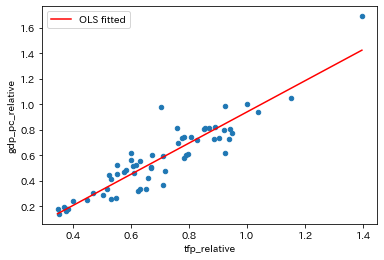

In [25]:
ax_ = df2019.plot(x='tfp_relative', y='gdp_pc_relative', kind='scatter')
df2019.sort_values('OLS fitted').plot(x='tfp_relative',
                                      y='OLS fitted',
                                      color='r', ax=ax_)
pass

```{admonition} コードの説明
:class: dropdown

２行目の`sort_values()`は引数の`'OLS fitted'`を基準に昇順に並べ替える。これを指定しないと直線が綺麗に表示されない。
```

````{note}
`gdp_pc_relative`の予測値は，属性`.fittedvalues`もしくはメソッド`.predict()`で取得できるが，次のコードでも同じ結果となる。
```
df2019['fitted'] = ahat + bhat * df2019.loc[:,'tfp_relative']
```
````

## 回帰分析による発展会計

(sec:6-regression-da)=

## 回帰分析による発展会計

### 説明

[発展会計](chap:5a-accounting)の式[](eq:riy-decomposition)では，米国の一人当たりGDPを基準として経済$i$の一人当たりGDPを次式で表した。

$$
r_i^y =
r_i^{\text{tfp}} +
r_i^{\text{factors}}
$$ (eq:6-riy)

ここで，
* $r_i^y$：一人当たりGDP（対数; 米国＝１）
* $r_i^{\text{tfp}}$：全要素生産性（対数; 米国＝１）
* $r_i^{\text{factors}}$：蓄積生産要素（対数; 米国＝１）

また，それぞれの貢献度を次式で数量化した。

$$
\text{全要素生産性の寄与度}
\equiv\beta_{\text{tfp}}=
\dfrac{
    \text{Var}\left(r_i^{\text{tfp}}\right)
    +\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)
    }{
    \text{Var}(r_i^y)
    }
$$ (eq:6-tfp-contribution)

$$
\text{蓄積生産要素の寄与度}
\equiv
\beta_{\text{factors}}=
\dfrac{
    \text{Var}\left(r_i^{\text{factors}}\right)
    +\text{Cov}\left(r_i^{\text{tfp}},r_i^{\text{factors}}\right)
    }{
    \text{Var}(r_i^y)
    }    
$$ (eq:6-factors-contribution)

この章では回帰分析を使って$\beta_{\text{tfp}}$と$\beta_{\text{factors}}$計算することができることを示す。そのために，まず次の関係が成立することを思い出そう。

$$
\text{Cov}(x,x)=\text{Var}(x)
$$

$$
\text{Cov}(x,y\pm z)=\text{Cov}(x,y)\pm\text{Cov}(x,z)
$$

これらを使うと[](eq:6-tfp-contribution)は次のように書き換えることができる。

$$
\beta_{\text{tfp}}
=\dfrac{
    \text{Var}\left(r_i^{\text{tfp}}\right)
    +\text{Cov}\left(r_i^{\text{tfp}},r_i^y-r_i^{\text{tfp}}\right)
    }{
    \text{Var}(r_i^y)
    }
=\dfrac{
    \text{Cov}\left(r_i^{\text{tfp}},r_i^{y}\right)
    }{
    \text{Var}(r_i^y)
    } 
$$ (eq:6-tfp-contribution-2)

蓄積生産要素の寄与度についても同様に次式で与えられる。

$$
\beta_{\text{factors}}
=\dfrac{
    \text{Cov}\left(r_i^{\text{factors}},r_i^{y}\right)
    }{
    \text{Var}(r_i^y)
    } 
$$ (eq:6-factors-contribution-2)

この結果が回帰分析とどのような関係にあるかを確認するために，次の単回帰式を考えよう。

$$
y_i = a + bx_i+e_i
$$

最小二乗法を使い推定すると，スロープ係数の推定値は次式で与えられることになる。

$$
\hat{b}=\dfrac{
            \text{Cov}\left(y,x\right)
            }{
            \text{Var}(x)
            } 
$$ (eq:6-bhat)

式[](eq:6-bhat)と２つの式[](eq:6-tfp-contribution-2)と[](eq:6-factors-contribution-2)から，次の回帰式を最小二乗法で推定すると$\beta_{\text{tfp}}$と$\beta_{\text{factors}}$を計算できることが分かる。

$$
\begin{align*}
&r_i^{\text{tfp}}=a+\beta_{\text{tfp}}r_i^{y}+e_i \\
&r_i^{\text{factors}}=c+\beta_{\text{factors}}r_i^{y}+u_i
\end{align*}
$$

以下では`statsmodels`を使って実際に計算してみよう。

### 最小二乗法による計算

`df2019`にある変数を使って，計算に使う変数を作成しよう。

In [34]:
# 労働者一人当たりGDP（USA=1）の対数化
df2019['gdp_pc_relative_log'] = np.log( df2019['gdp_pc_relative'] )

# 全要素生産性（USA=1）の対数化
df2019['tfp_relative_log'] = np.log( df2019['tfp_relative'] )

# 蓄積生産要素（USA=1）の対数化
df2019['factors_relative_log'] = np.log( df2019['factors_relative'] )

次に推定式を定義する。

In [35]:
formula_tfp = 'tfp_relative_log ~ gdp_pc_relative_log'
formula_factors = 'factors_relative_log ~ gdp_pc_relative_log'

自動計算のための準備をし，実際に計算した結果を変数に割り当てる。

In [36]:
result_tfp = smf.ols(formula_tfp, data=df2019).fit()
result_factors = smf.ols(formula_factors, data=df2019).fit()

パラメータの値を表示してみよう。

In [37]:
print(f'全要素生産性の寄与度：{result_tfp.params.iloc[1]}\n'
      f'蓄積生産要素の寄与度：{result_factors.params.iloc[1]}')

全要素生産性の寄与度：0.5391873123319041
蓄積生産要素の寄与度：0.46081268766809547


```{admonition} コードの説明
:class: dropdown

* `f`は以前説明した`f-string`を使って`{}`に値を代入している。
* `()`は複数行にしても構わない。
* `''`で囲んだ文字列を複数行にする場合は，それぞれの行で閉じる必要がある。
* `\n`は改行という意味。
```

[全要素生産性と蓄積生産要素の寄与度](sec:5-tfp-factors)で計算した値と同じになることが確認できる。